# Installing Necessary Libraries

In [ ]:
!pip install tensorflow-gpu
!pip install keras
!pip install python=opencv
!pip install matplotlib
!pip install numpy

# Importing Necessary Libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import zipfile

# Mounting G-Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Replace 'file_path.rar' with the path to your .rar file
file_path = '/content/drive/MyDrive/IIITB-FACES-20231216T134817Z-001.zip'

# Unzip the file
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content')


In [ ]:
image_dir = "/content/IIITB-FACES"

# Iterate through the folders in the main directory
images = []
for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png', '.gif')):  # Add more image extensions if needed
            image_path = os.path.join(root, file)
            images.append(image_path)

# Display the first two elements of the list
print(images[:2])

['/content/IIITB-FACES/IMT2013059/2.jpg', '/content/IIITB-FACES/IMT2013059/13.jpg']


In [ ]:
#length of the dataset
len(images)

832

CHECKING AVG DIMENSION OF ALL THE IMAGES

In [ ]:
#checking avg dimension of all the images
from PIL import Image

# Initialize variables to store total width and height
total_width = 0
total_height = 0

# Loop through each image and accumulate width and height
for image_file in images:
    with Image.open(image_file) as img:
        width, height = img.size
        total_width += width
        total_height += height

# Calculate average dimensions
avg_width = total_width / len(images)
avg_height = total_height / len(images)

print(f"Average width: {avg_width}, Average height: {avg_height}")

Average width: 499.9266826923077, Average height: 499.30408653846155


PREPROCESSING

FACE DETECTION

In [ ]:
import cv2
# Create a folder to save the cropped images
output_folder = "/content/Face_detection"
os.makedirs(output_folder, exist_ok=True)

# Load the pre-trained Haar Cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load and process each image
for i in range(len(images)):
    # Load the image
    image = cv2.imread(images[i])

    # Convert the image to grayscale for face detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Perform face detection
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    #print(type(faces))
    #print(faces.shape)

    # Crop and save each detected face
     # Check if faces is a tuple (handles the case where no faces are detected)

    if isinstance(faces, tuple):
        continue

    if faces.shape[0]>=1:
        x, y, w, h = faces[0]
        face_image = image[y:y+h, x:x+w]
        output_path = os.path.join(output_folder, f"face_{i+1}.jpg")
        cv2.imwrite(output_path, face_image)

In [ ]:
# preprocess
image_size = 256

def preprocess(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image = image / 255.0
    image = tf.reshape(image, shape = (image_size, image_size, 3,))
    return image

In [ ]:
image_dir = "/content/Face_detection"

# Iterate through the folders in the main directory
images = []
for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png', '.gif')):  # Add more image extensions if needed
            image_path = os.path.join(root, file)
            images.append(image_path)

batch_size = 128
training_dataset = tf.data.Dataset.from_tensor_slices((images))
training_dataset = training_dataset.map(preprocess)
training_dataset = training_dataset.shuffle(1000).batch(batch_size)

In [ ]:
len(training_dataset)

7

# Visualizing Some of The Images From The Dataset

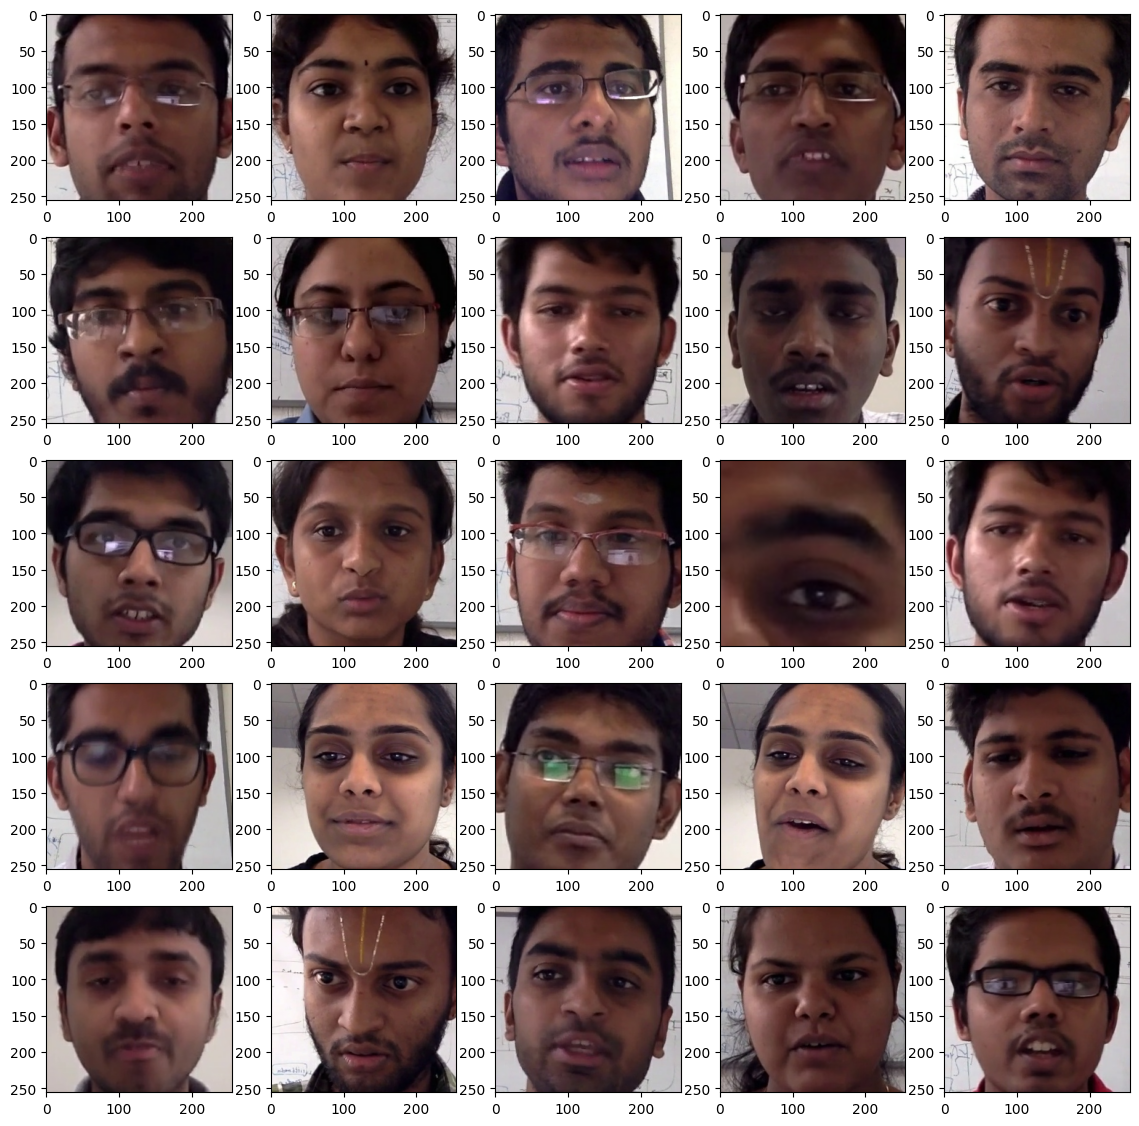

In [ ]:
# visualize some of them
fig, axes = plt.subplots(5,5, figsize = (14,14))
sample = training_dataset.unbatch().take(25)
sample = [image for image in sample]

idx = 0
for row in range(5):
    for column in range(5):
        axes[row, column].imshow(sample[idx])
        idx+=1

# Building The Model

In [ ]:

# build the model
latent_dim = 512

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation, LeakyReLU
from keras.activations import selu
from keras.layers import Multiply, Add
from keras.optimizers import Adam
from keras import backend as K

In [ ]:
K.clear_session()

# Encoder

In [ ]:
encoder_input = Input(shape = (256,256,3))

x = Conv2D(32, kernel_size=5, activation = LeakyReLU(0.02), strides = 1, padding = 'same')(encoder_input)
x = BatchNormalization()(x)

filter_size = [64,128,256,512]
for i in filter_size:
    x = Conv2D(i, kernel_size=5, activation = LeakyReLU(0.02), strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(1024, activation = selu)(x)
encoder_output = BatchNormalization()(x)

# sampling layer
mu = Dense(latent_dim)(encoder_output)
log_var = Dense(latent_dim)(encoder_output)

epsilon = K.random_normal(shape = (tf.shape(mu)[0], tf.shape(mu)[1]))
sigma = tf.exp(0.5 * log_var)

z_eps = Multiply()([sigma, epsilon])
z = Add()([mu, z_eps])

encoder = Model(encoder_input, outputs = [mu, log_var, z], name = 'encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         2432      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         51264     ['batch_normalization[0]

# Decoder

In [ ]:
# build the decoder

decoder = Sequential()
decoder.add(Dense(1024, activation=selu, input_shape=(latent_dim,)))
decoder.add(BatchNormalization())

decoder.add(Dense(8192, activation=selu))
decoder.add(Reshape((8, 8, 128)))

decoder.add(Conv2DTranspose(256, (5, 5), activation=LeakyReLU(0.02), strides=2, padding='same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(128, (5, 5), activation=LeakyReLU(0.02), strides=2, padding='same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(64, (5, 5), activation=LeakyReLU(0.02), strides=2, padding='same'))

# Modify this layer to achieve the desired output shape of 256x256
decoder.add(Conv2DTranspose(3, (5, 5), activation="sigmoid", strides=4, padding='same'))
decoder.add(BatchNormalization())

decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization_6 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 8192)              8396800   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 256)       819456    
 anspose)                                                        
                                                                 
 batch_normalization_7 (Bat  (None, 16, 16, 256)       1

# Defining Loss

In [ ]:
# make loss function
# vae loss = reconstruction loss + KL div

def reconstruction_loss(y, y_pred):
    return tf.reduce_mean(tf.square(y - y_pred))

def kl_loss(mu, log_var):
    loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
    return loss

def vae_loss(y_true, y_pred, mu, log_var):
    return reconstruction_loss(y_true, y_pred) + (1 / (64*64)) * kl_loss(mu, log_var)

# Creating VAE by combining Encoder and Decoder

In [ ]:
# conbine encoder and decoder
mu, log_var, z = encoder(encoder_input)
reconstructed = decoder(z)
model = Model(encoder_input, reconstructed, name ="vae")
loss = kl_loss(mu, log_var)
model.add_loss(loss)
model.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 encoder (Functional)        [(None, 512),                1396318   ['input_1[0][0]']             
                              (None, 512),                08                                      
                              (None, 512)]                                                        
                                                                                                  
 sequential (Sequential)     (None, 256, 256, 3)          1077620   ['encoder[0][2]']             
                                                          7                                     

In [ ]:
# make a function to save images while learning
def save_images(model, epoch, step, input_):
    prediction = model.predict(input_)
    fig, axes = plt.subplots(5,5, figsize = (14,14))
    idx = 0
    for row in range(5):
        for column in range(5):
            image = prediction[idx] * 255
            image = image.astype("int32")
            axes[row, column].imshow(image)
            axes[row, column].axis("off")
            idx+=1
    output_path = "/content/output/"
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    plt.savefig(output_path + "Epoch_{:04d}_step_{:04d}.jpg".format(epoch, step))
    plt.close()

# Training

In [ ]:
# train vae

from keras.optimizers import Adam

random_vector = tf.random.normal(shape = (25, latent_dim,))
save_images(decoder, 0, 0, random_vector)

mse_losses = []
kl_losses = []

optimizer = Adam(0.0001, 0.5)
epochs = 1500

for epoch in range(1, epochs + 1):
    print("Epoch: ", epoch)
    for step, training_batch in enumerate(training_dataset):
        with tf.GradientTape() as tape:
            reconstructed = model(training_batch)
            y_true = tf.reshape(training_batch, shape = [-1])
            y_pred = tf.reshape(reconstructed, shape = [-1])

            mse_loss = reconstruction_loss(y_true, y_pred)
            mse_losses.append(mse_loss.numpy())

            kl = sum(model.losses)
            kl_losses.append(kl.numpy())

            train_loss = 0.01 * kl + mse_loss

            grads = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            if step % 20 == 0 or step % 241 == 0:
                save_images(decoder, epoch, step, random_vector)
            print("Epoch: %s - Step: %s - MSE loss: %s - KL loss: %s" % (epoch, step, mse_loss.numpy(), kl.numpy()))

1/1 [==============================] - 3s 3s/step
Epoch:  1


1/1 [==============================] - 0s 31ms/step
Epoch: 1 - Step: 0 - MSE loss: 0.08020973 - KL loss: 0.0006859753
Epoch: 1 - Step: 1 - MSE loss: 0.08047008 - KL loss: 0.00051259325
Epoch: 1 - Step: 2 - MSE loss: 0.08113988 - KL loss: 0.0003547331
Epoch: 1 - Step: 3 - MSE loss: 0.08070142 - KL loss: 0.00026828
Epoch: 1 - Step: 4 - MSE loss: 0.08250414 - KL loss: 0.0001880342
Epoch: 1 - Step: 5 - MSE loss: 0.08131607 - KL loss: 0.0001494721
Epoch: 1 - Step: 6 - MSE loss: 0.08203772 - KL loss: 0.00011043126
Epoch:  2
1/1 [==============================] - 1s 884ms/step
Epoch: 2 - Step: 0 - MSE loss: 0.07994955 - KL loss: 0.00010022173
Epoch: 2 - Step: 1 - MSE loss: 0.07939082 - KL loss: 8.502885e-05
Epoch: 2 - Step: 2 - MSE loss: 0.0809514 - KL loss: 8.169455e-05
Epoch: 2 - Step: 3 - MSE loss: 0.07990389 - KL loss: 7.287713e-05
Epoch: 2 - Step: 4 - MSE loss: 0.08178811 - KL loss: 7.1493094e-05
Epoch: 2 - Step: 5 - MSE loss: 0.079277776 - KL loss: 8.148319e-05
Epoch: 2 - Step: 6 - MSE 

In [ ]:
import zipfile
import os
# Folder path to be zipped
folder_path = '/content/output'

# Name for the zip file
zip_file_name = '/content/output.zip'

# Zip the folder
with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), folder_path))